<a href="https://colab.research.google.com/github/taemmini/2023_Fall_HUFS_ML_Project_7/blob/main/CAPTCHA_Project_CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf #딥러닝에 많이 쓰이는 라이브러리
from tensorflow import keras
from keras import layers #신경망 구성에 관한 라이브러리

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import cv2 #openCV

In [35]:
images = glob("/content/captcha_images/*.png")
print(images[0].split(os.path.sep)[3].split(".png")[0])

ZE25


In [36]:
labels = [img.split(os.path.sep)[3].split(".png")[0] for img in images]
print(len(labels))

9955


In [37]:
unique_char = set(''.join(labels))
print(unique_char)
print(len(unique_char))

{'E', 'K', 'F', '6', 'R', '2', '7', '8', 'S', 'W', 'G', 'H', 'B', 'P', 'L', 'N', 'A', 'J', '5', 'T', 'U', 'V', '3', 'M', 'D', 'C', 'Y', 'Z', 'X', 'Q', '9', '4'}
32


In [38]:
# label 인코딩

# Keras에서 제공하는 문자열 -> 숫자 label 매칭을 사용해 label을 int로 바꿈
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary = list(unique_char), num_oov_indices = 0, mask_token = None
)
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), num_oov_indices = 0, mask_token = None, invert = True
)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [39]:
# 인코딩 테스트
print(labels[0], end=" / ")
example = char_to_num(tf.strings.unicode_split(labels[0], input_encoding = 'UTF-8'))
print(example)

ZE25 / tf.Tensor([27  0  5 18], shape=(4,), dtype=int64)


In [40]:
# 한국어도 가능한가?
test_set = set(["가","나","다","라","마","걁","샯"])
char_to_num_test = layers.experimental.preprocessing.StringLookup(
    vocabulary = list(test_set), num_oov_indices = 0, mask_token = None
)
num_to_char_test = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num_test.get_vocabulary(), num_oov_indices = 0, mask_token = None, invert = True
)
test_hangul_label = '가라걁다샯'
example_hangul = char_to_num_test(tf.strings.unicode_split(test_hangul_label, input_encoding = 'UTF-8'))
print(example_hangul)

tf.Tensor([2 1 6 3 4], shape=(5,), dtype=int64)


In [41]:
# 디코딩 테스트 (tf -> numpy byte array -> decode)

print(tf.strings.reduce_join(num_to_char(example)).numpy().decode('utf-8'))
print(tf.strings.reduce_join(num_to_char_test(example_hangul)).numpy().decode('utf-8'))

# 문제없이 작동함을 확인

ZE25
가라걁다샯


In [42]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=777)
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

8959 996
8959 996


E96X


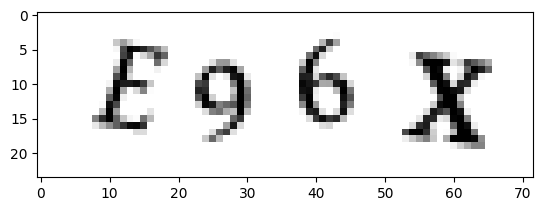

In [43]:
# 제대로 매칭되어 있는지 확인
sample = cv2.imread(x_train[0])
print(y_train[0])
plt.imshow(sample)

In [44]:
img_width = 72
img_height = 24

def encode_image(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [img_height, img_width])
  img = tf.transpose(img, perm=[1,0,2])

  label = char_to_num(tf.strings.unicode_split(label, input_encoding = 'UTF-8'))

  return {'image':img, 'label':label}

ZE25
tf.Tensor([27  0  5 18], shape=(4,), dtype=int64)


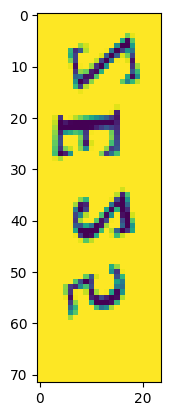

In [45]:
preview = encode_image(images[0], labels[0])
print(labels[0])
print(preview['label'])
plt.imshow(preview['image'])

In [46]:
# 모델에 넣을 데이터셋 구성(배치 학습이 아니기 때문에 정해진 배치사이즈마다 일정한 양의 데이터 묶음을 넣어 학습 진행)

batch_size = 32

# tf가 제공하는 Dataset을 사용하는게 학습이 더 빨라서 일반적으로 사용하는 것 같습니다.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(test_dataset)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 72, 24, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 72, 24, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


In [47]:
# CTC손실함수 정의 : 정형화된 구현 방법이 존재하여 그대로 가져왔습니다.

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [48]:
def build_model():
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    # Convolution, Maxpooling을 각각 두번하여 차원을 축소함

    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNN을 두 차례 사용
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # 출력층 구성
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2'
    )(x)

    # CTC 손실함수 적용
    output = CTCLayer(name='ctc_loss')(labels, x)

    # 모델 구성
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name='ocr_model_v1'
    )
    # 케라스에서 제공하는 최적화
    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model

In [49]:
# 학습

model = build_model()

epochs = 100
stopping_patience = 10 # 10번의 epoch동안 개선이 없을 시 종료
#restore_best_weights : 조기종료 후 지금까지 최적값을 냈던 가중치를 다시 선택함
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=stopping_patience, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
280/280 [==============================] - 22s 45ms/step - loss: 15.6520 - val_loss: 15.3166
Epoch 2/100
280/280 [==============================] - 10s 34ms/step - loss: 14.8478 - val_loss: 14.2291
Epoch 3/100
280/280 [==============================] - 12s 43ms/step - loss: 13.6264 - val_loss: 12.5401
Epoch 4/100
280/280 [==============================] - 11s 39ms/step - loss: 11.8068 - val_loss: 10.4593
Epoch 5/100
280/280 [==============================] - 11s 39ms/step - loss: 10.0909 - val_loss: 8.8923
Epoch 6/100
280/280 [==============================] - 11s 39ms/step - loss: 8.7374 - val_loss: 7.6323
Epoch 7/100
280/280 [==============================] - 11s 40ms/step - loss: 7.4669 - val_loss: 6.2278
Epoch 8/100
280/280 [==============================] - 11s 39ms/step - loss: 6.2339 - val_loss: 4.9429
Epoch 9/100
280/280 [==============================] - 10s 37ms/step - loss: 5.2355 - val_loss: 4.1256
Epoch 10/100
280/280 [==============================] - 14s 49ms

In [50]:
label_length = [len(label) for label in labels]
max_length = max(label_length)

1/1 [==============================] - 6s 6s/step


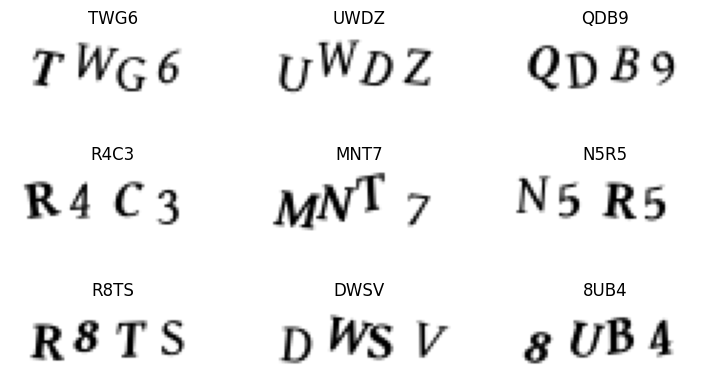

In [55]:
# 입력층, 출력층을 설정하여 예측 모델을 구성
prediction_model = keras.models.Model(
  model.get_layer(name='image').input, model.get_layer(name='dense2').output
)

# 실제로 예측을 하기 위한 코드
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    # encode된 글자를 복원하여 리스트에 저장
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

# test_dataset에서, 1batch만큼을 꺼내서 예측을 시도
for batch in test_dataset.take(1):
    batch_images = batch['image']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(3, 3, figsize=(9, 5))

    for img, text, ax in zip(batch_images, pred_texts, axes.flatten()):
        img = img.numpy().squeeze()
        img = img.T # 이미지처리 과정에서 Transpose했던 것을 다시 복구함

        ax.imshow(img, cmap='gray')
        ax.set_title(text)
        ax.set_axis_off()

In [53]:
!mkdir -p models

In [54]:
model.save("/content/models")